<a href="https://colab.research.google.com/github/Ayavie/arabic-fake-name-detection/blob/main/Valid_name_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Description ☕
This notebook is created to tackle invalid name detection problem. NLP techniques are used to handle this problem.

The challenge is to find the best way of preprocessing techniques for arabic names and creating the best combination of sequence model layers to get better outcome.

The impact could be having much less fake arabic names in websites registeration by banning the fake ones for example.

## Strategy used ✔️

* Importing libraries and Investigation data
* Data Preprocessing
* Creating Bidirectional LSTM Model
* Model Training
* Model Evaluation
* Model Tuning 
* Model Re-load and Re-use

In [1]:
#Imporing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam,Nadam
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
tf.random.set_seed(1234)


## Exploratory Data Analysis

In [2]:
df = pd.read_csv("/content/drive/MyDrive/name_model/namesdataset.csv")
df

,name,gender,valid
0,حسحاس نجدة تركي,M,1
1,نصر نعمت زيدون,M,1
2,جساس فيضي فهيم,M,1
3,داود مالك رامز,M,1
4,رائد مناع مستور,M,1
...,...,...,...
3999995,تمن ثاتضتابجر,F,0
3999996,ميانممككومه لمطوع,F,0
3999997,نكقذخلارخم نص,F,0
3999998,يصمصميا مهمهب,F,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   name    object
 1   gender  object
 2   valid   int64 
dtypes: int64(1), object(2)
memory usage: 91.6+ MB


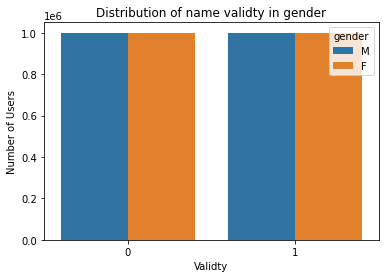

In [4]:
# Checking class balance and gender balance
sb.countplot(data = df, x = 'valid', hue = 'gender');
plt.title('Distribution of name validty in gender');
plt.xlabel('Validty');
plt.ylabel ('Number of Users');

Now, we are sure that classes are and gender are balanced to avoid any sampling bias.

In [5]:
# Max length of name
print("Max length of names: ",df['name'].map(lambda x: len(x)).max())

# Min length of name
print("Min length of names: ",df['name'].map(lambda x: len(x)).min())

Max length of names:  36
Min length of names:  9


In [6]:
# Check number of duplicates 
df.duplicated().sum()

7173

We will drop the duplicates to avoid data leakage (Presence of the same data points in training and test sets)

and it's okay because it won't hurt class balance as it is considered 0.0018% of our data

## Data Preprocessing


Let's drop duplicates.

In [7]:
df.drop_duplicates(inplace=True)
print("Number of duplicates now: ",df.duplicated().sum())

Number of duplicates now:  0


Let's drip "gender" column

In [8]:
df.drop(columns=["gender"],inplace=True)

#Making sure by printing column names
df.columns

Index(['name', 'valid'], dtype='object')

Let's split the data into train and test splits!

In [9]:
X=df['name']
y=df['valid']

We will only test with 100k of the data which is 0.025 of it

In [10]:
# Train-test split
xtr,xts,ytr,yts=train_test_split(X,y, test_size=0.025,stratify=y,random_state=42,shuffle=True)

In this problem, we will tokenize names character-wise as we can tell a name is valid or fake by knowing the combination of characters.

In [12]:
max_len = 36  #Longest name length

# Build characters vocabulary from training set
tokenizer = Tokenizer(num_words=False,char_level=True,oov_token='UNK')
# Fit the tokenizer on names in training set
tokenizer.fit_on_texts(xtr)

# function to preprocess the text by adding padding to make all of training examples of same max length (36 char)
def _preprocess(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text),
        maxlen=max_len,
        padding='post',
    )

# Print tokenizer vocabulary after fitting on training set
tokenizer.word_index

{'UNK': 1,
 ' ': 2,
 'ا': 3,
 'م': 4,
 'ي': 5,
 'ر': 6,
 'ن': 7,
 'د': 8,
 'ب': 9,
 'ل': 10,
 'س': 11,
 'ف': 12,
 'و': 13,
 'ة': 14,
 'ع': 15,
 'ح': 16,
 'ه': 17,
 'ج': 18,
 'ت': 19,
 'ز': 20,
 'ك': 21,
 'ق': 22,
 'ص': 23,
 'ط': 24,
 'ش': 25,
 'أ': 26,
 'خ': 27,
 'ض': 28,
 'ث': 29,
 'غ': 30,
 'ظ': 31,
 'ذ': 32,
 'ء': 33,
 'إ': 34,
 'ئ': 35,
 'ى': 36,
 'ؤ': 37,
 'آ': 38}

In [13]:
# saving tokenizer object for later use
pickle.dump(tokenizer, open('/content/drive/MyDrive/name_model/tokenizer4.pickle', 'wb'),protocol=4)

In [65]:
#pickle.dump(tokenizer, open('/content/drive/MyDrive/name_model/tokenizer5.pickle', 'wb'),protocol=5)

In [16]:
vocab_size=500 

Let's preprocess training data (Add padding)

In [17]:
# padding is added
pre_name = _preprocess(xtr)
print(pre_name.shape)

(3893006, 36)


The data dimension after preprocessing represent (Number of training examples, length_of_each_training_example)

In [18]:
# Check the first name vector
print("First vector: ", pre_name[0])
print("First vector shape: ",pre_name[0].shape)

First vector:  [32  9  5  3  7 14  2  4 12 19  3 16  2  6  5  3  7  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
First vector shape:  (36,)


In [19]:
# Convert vector IDs to words
print(tokenizer.sequences_to_texts(pre_name[:1]))

['ذ ب ي ا ن ة   م ف ت ا ح   ر ي ا ن UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK']


Let's preprocess test data as well

In [20]:
# Add padding to test set to have max length
pre_name_t = _preprocess(xts)

## Model Building
We will use sequence model to tackle this problem as it considers dependencies of sequential order.

> * The model's input: gender and name
> * The model's output: accuracy of validity
> * Using "Accuracy" as a metric is a good choice 

In [22]:
# Input of both name and gender
in_name=tf.keras.Input(batch_shape=(None, max_len),name='name')

# Embedding layer and two Bidirectional LSTM
embedded = tf.keras.layers.Embedding(vocab_size, 50)(in_name)
bi1= tf.keras.layers.Bidirectional(keras.layers.LSTM(4, return_sequences=True))(embedded)
bi2= tf.keras.layers.Bidirectional(keras.layers.LSTM(2, return_sequences=False))(bi1)
# Final layer of judgement which has sigmoid for binary classification
valid = Dense(1,activation='sigmoid') (bi2)

# define model input/output using keys
model = keras.Model(
    inputs=in_name,
    outputs = valid   
)

# Model compilation of metrics used 
model.compile(
    optimizer=Adam(),
    loss= 'binary_crossentropy',
    metrics='Accuracy',
     

)

#Printing Model Summary
print(model.summary())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 name (InputLayer)           [(None, 36)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 36, 50)            25000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 36, 8)            1760      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 4)                176       
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 26,941
Trainable params: 26,941
Non-trainable

Let's plot the model

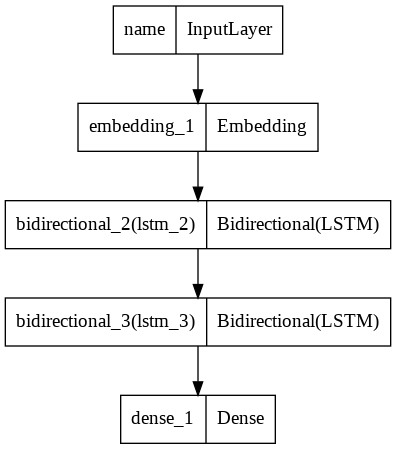

In [23]:
tf.keras.utils.plot_model(
model, to_file='model.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

###Train the model on training set

In [24]:
history = model.fit(
    x=pre_name,
    y=ytr,
    epochs=30,
    batch_size=512,
    validation_split=0.025,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True )
    ],
    verbose=1
)

Epoch 1/30
7414/7414 [==============================] - 638s 85ms/step - loss: 0.3345 - Accuracy: 0.8559 - val_loss: 0.2617 - val_Accuracy: 0.8986
Epoch 2/30
7414/7414 [==============================] - 583s 79ms/step - loss: 0.2332 - Accuracy: 0.9124 - val_loss: 0.2138 - val_Accuracy: 0.9217
Epoch 3/30
7414/7414 [==============================] - 585s 79ms/step - loss: 0.1932 - Accuracy: 0.9315 - val_loss: 0.1739 - val_Accuracy: 0.9405
Epoch 4/30
7414/7414 [==============================] - 600s 81ms/step - loss: 0.1683 - Accuracy: 0.9431 - val_loss: 0.1566 - val_Accuracy: 0.9489
Epoch 5/30
7414/7414 [==============================] - 614s 83ms/step - loss: 0.1505 - Accuracy: 0.9513 - val_loss: 0.1422 - val_Accuracy: 0.9548
Epoch 6/30
7414/7414 [==============================] - 617s 83ms/step - loss: 0.1385 - Accuracy: 0.9566 - val_loss: 0.1334 - val_Accuracy: 0.9587
Epoch 7/30
7414/7414 [==============================] - 639s 86ms/step - loss: 0.1283 - Accuracy: 0.9606 - val_loss: 0

In [80]:
# Saving the model
pickle.dump(model, open('/content/drive/MyDrive/name_model/model.pickle', 'wb'),protocol=4)

In [37]:
# Saving the model
#pickle.dump(model, open('/content/drive/MyDrive/datasets/model5.pickle', 'wb'),protocol=5)

###Evaluate the model performance using test data

In [29]:
model.evaluate(pre_name_t,yts)

3120/3120 [==============================] - 34s 11ms/step - loss: 0.0606 - Accuracy: 0.9835


[0.06061725318431854, 0.9834503531455994]

Extract "Accuracy" values of test data to determine the label

In [30]:
y_predict = model.predict(pre_name_t)

3120/3120 [==============================] - 33s 10ms/step


In [31]:
y_predict

array([[3.9954495e-05],
       [3.1893698e-05],
       [9.8957807e-01],
       ...,
       [2.0227873e-05],
       [9.7858703e-01],
       [1.3432930e-04]], dtype=float32)

In [32]:
# Detect label of predictions
def make_label(list_of_preds):
  "This function takes list of accuracies of predictions and returns a label 1 of valid name and 0 if invalid name"
  y_pred_labels=[]
  for i in range(len(y_predict)):
      if y_predict[i] > 0.5:
          y_pred_labels.append(1)
      else:
          y_pred_labels.append(0)
  return y_pred_labels

In [33]:
y_pred_labels=make_label(y_predict)

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(yts, y_pred_labels) ## confusion matrix
class_report = classification_report(yts,y_pred_labels,zero_division=1) ## classification report
print("Confusion matrix\n\n" ,conf_matrix , "\n")
print(class_report)

Confusion matrix

 [[48375  1613]
 [   39 49794]] 

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     49988
           1       0.97      1.00      0.98     49833

    accuracy                           0.98     99821
   macro avg       0.98      0.98      0.98     99821
weighted avg       0.98      0.98      0.98     99821



The model Neither suffers from overfitting nor underfitting as the testing accuracy is almost the same accuracy of the best model in training.

But the True Negative is 1.6K which means there are alot of valid names the model didn't recognize.

As a solution to that I consider in future work to change strategy of creating the dataset, in which the names should be created with all combination of names. This would help the model catch the valid name but will provide more resources as well.

Let's check rate of True Positive and True Negative to get intuition how to set a threshold for label prediction.

In [74]:
avg_tp_rate=[]
avg_tn_rate=[]
for i in range(len(yts)):
  if yts.iloc[i]==1:
    if yts.iloc[i]==y_pred_labels[i]:
      avg_tp_rate.append(y_predict[i][0])
  else:
    if yts.iloc[i]==y_pred_labels[i]:
      avg_tn_rate.append(y_predict[i][0])
print("Average of Accuracies of True Positive rate ",np.mean(avg_tp_rate))
print("Average of Accuracies of True Negative rate ",np.mean(avg_tn_rate))


Average of Accuracies of True Positive rate  0.97376466
Average of Accuracies of True Negative rate  0.0013849922


There's a huge gab between the two rates which implies the certainty of model about both valid names and also invalid names. I believe we can set a threshold close to 0.97. We'll set a threshold of value $0.9$.

#### Accuracy and Loss Curves

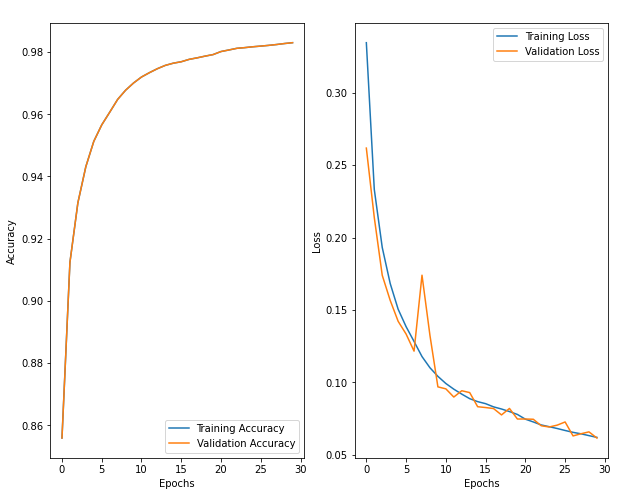

In [35]:
# Plotting  model training accuracy and validation accuracy curves with epochs 
plt.figure(figsize=(10, 8), )
plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['Accuracy'], label='Training Accuracy')
plt.plot(history.history['Accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('                         ')

# Plotting  model training loss and validation loss curves with epoch
plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

We can tell from the graphs that training and validation accuracy are almost the same (as we can not see training accuracy curve).

As for the loss, it started with a bigger value than validation loss which is okay as they don't have big difference but overall, the loss for both curves are decreasing ina monotonic pattern which is good (Expect for one part).

In [36]:
model.save('/content/drive/MyDrive/name_model/name_model_char_bi30')

## Model Re-load and Re-use
This part is dedicated for making fast predictions without needing to run all above code.

It has all needed imports and functions and model loading.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [42]:
# Loading Model
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/name_model/name_model_char_bi30")

# Or we can use pickled model
# pickled_model = pickle.load(open('model.pkl', 'rb'))

In [43]:
# loading tokenizer object
tokenizer = pickle.load(open('/content/drive/MyDrive/name_model/tokenizer4.pickle', 'rb'))

In [39]:
def _preprocess(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text),
        maxlen=max_len,
        padding='post',
    )
def predict_acc(name):
  pre_name=_preprocess([name])  
  label=reconstructed_model.predict(pre_name)[0][0]
  return label


In [63]:
# Detect label of predictions
def make_label(list_of_preds):
  "This function takes list of accuracies of predictions and returns a label 1 of valid name and 0 if invalid name"
  y_pred_labels=[]
  for i in range(len(list_of_preds)):
      if list_of_preds[i] > 0.9: #our chosen threshold
          y_pred_labels.append(1)
      else:
          y_pred_labels.append(0)
  return y_pred_labels[0]

In [79]:
name= "آية هشام أحمد"
acc=predict_acc(name)
acc

1/1 [==============================] - 0s 26ms/step


0.99159855

In [64]:
make_label([acc])

1